In [1]:
import sys
import os
os.chdir('../')
import matplotlib.pyplot as plt
import torch
from   bin.model import BrainMimic
import networkx as nx
import nibabel as nib
import pandas as pd
import json


220615-18:53:26,461 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.1
Intel Hardware Acceleration is not enabled. 


In [2]:
structure_graph_path = '/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1_frozen_20220527/misc_testing_files/fully_connected_simple.gml'  # path to shape color graph
data = json.load(open(structure_graph_path, 'r'))
gt = nx.readwrite.node_link_graph(data)

In [3]:
# prune gt
for s, t, data in list(gt.edges(data=True)):
    if abs(data['weight']) < .5:
        gt.remove_edge(s, t)

In [4]:
roi_atlas = nib.load('/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1_frozen_20220527/D99_v2.0_dist/simplified_atlas.nii')

In [5]:
start_node = None
for n, data in gt.nodes(data=True):
    if data['roi_name'] == 'V1':
        start_node = n
        break
echo = BrainMimic(gt, start_node, units_per_voxel=1, stimuli_shape=(1, 3, 64, 64), start_lr=.01)
echo.load_network_state('/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/misc_testing_files/SL_brain_mimic_epoch_2_19')

added computational node 0 mPFC with size (1, 598, 1, 1)
added computational node 1 oPFC with size (1, 302, 2, 2)
added computational node 2 vlPFC with size (1, 109, 4, 4)
added computational node 3 ant-IT with size (1, 1325, 1, 1)
added computational node 4 STS with size (1, 745, 2, 2)
added computational node 5 hippocampus with size (1, 382, 1, 1)
added computational node 6 TE with size (1, 1095, 1, 1)
added computational node 7 V3 with size (1, 5, 16, 16)
added computational node 8 V3a with size (1, 2, 16, 16)
added computational node 9 V4 with size (1, 10, 16, 16)
added computational node 10 MT with size (1, 4, 16, 16)
added computational node 11 V2 with size (1, 5, 32, 32)
added computational node 12 V1 with size (1, 2, 64, 64)
added computational node 13 putamen with size (1, 1335, 1, 1)
added computational node 14 globbus-pallidus-internal with size (1, 156, 1, 1)
added computational node 15 globbus-pallidus-external with size (1, 352, 1, 1)
added computational node 16 claustrum

In [6]:
# load paradigm data
from dataloaders import dyloc_data_loader, shape_color_dataloader
stimuli = [shape_color_dataloader.ShapeColorBasicData("/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/stimuli/small_stimuli", exp_image_size=(64, 64)),
           dyloc_data_loader.DylocDataloader("/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/stimuli/dyloc_downsampled", exp_image_size=(64, 64), stim_frames=10)]



********************
META: SUPER Epoch # 0
********************

********************
META: LOCAL Epoch #  0 (auper epoch 0 )
********************

********************
PRESENTING paradigm shape_color_basic
********************

PRESENTING cond colored_circle frame 0

PRESENTING cond colored_circle frame 1

PRESENTING cond colored_circle frame 2

PRESENTING cond colored_circle frame 3

PRESENTING cond colored_circle frame 4

PRESENTING cond colored_circle frame 5

PRESENTING cond colored_circle frame 6

PRESENTING cond colored_circle frame 7

PRESENTING cond colored_circle frame 8

PRESENTING cond colored_circle frame 9

PRESENTING cond colored_circle frame 10

PRESENTING cond colored_circle frame 11

PRESENTING cond colored_circle frame 12

PRESENTING cond colored_circle frame 13

PRESENTING cond colored_circle frame 14

PRESENTING cond colored_circle frame 15

PRESENTING cond colored_circle frame 16

PRESENTING cond colored_circle frame 17

PRESENTING cond colored_circle frame 18

P

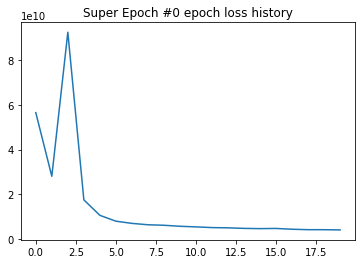

Pruning, factor= 0.02
current number edges: 107
average weight : 0.0894240289926529 weight std 0.005598569288849831
Pruned edge  V4 -> MT with weight 0.08506800979375839
Pruned edge  V2 -> V1 with weight 0.08374281227588654
Pruned edge  frontal-eye-field  -> V3a with weight 0.0814710408449173

********************
META: SUPER Epoch # 1
********************

********************
META: LOCAL Epoch #  0 (auper epoch 1 )
********************

********************
PRESENTING paradigm shape_color_basic
********************

PRESENTING cond chromatic_shape_uncolored frame 0

PRESENTING cond chromatic_shape_uncolored frame 1

PRESENTING cond chromatic_shape_uncolored frame 2

PRESENTING cond chromatic_shape_uncolored frame 3

PRESENTING cond chromatic_shape_uncolored frame 4

PRESENTING cond chromatic_shape_uncolored frame 5

PRESENTING cond chromatic_shape_uncolored frame 6

PRESENTING cond chromatic_shape_uncolored frame 7

PRESENTING cond chromatic_shape_uncolored frame 8

PRESENTING cond c

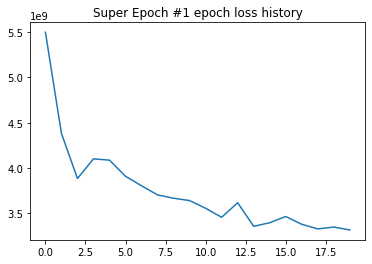

Pruning, factor= 0.01866065983073615
current number edges: 104
average weight : 0.09232068061828613 weight std 0.005365286488085985
Pruned edge  V2 -> MT with weight 0.08782214671373367
Pruned edge  V1 -> V3a with weight 0.08838695287704468

********************
META: SUPER Epoch # 2
********************

********************
META: LOCAL Epoch #  0 (auper epoch 2 )
********************

********************
PRESENTING paradigm shape_color_basic
********************

PRESENTING cond chromatic_shape_uncolored frame 0

PRESENTING cond chromatic_shape_uncolored frame 1

PRESENTING cond chromatic_shape_uncolored frame 2

PRESENTING cond chromatic_shape_uncolored frame 3

PRESENTING cond chromatic_shape_uncolored frame 4

PRESENTING cond chromatic_shape_uncolored frame 5

PRESENTING cond chromatic_shape_uncolored frame 6

PRESENTING cond chromatic_shape_uncolored frame 7

PRESENTING cond chromatic_shape_uncolored frame 8

PRESENTING cond chromatic_shape_uncolored frame 9

PRESENTING cond chr

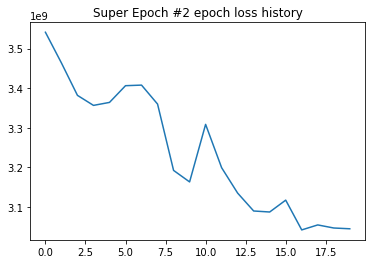

Pruning, factor= 0.017411011265922482
current number edges: 102
average weight : 0.09288670122623444 weight std 0.0055601284839212894
Pruned edge  V3a -> V4 with weight 0.08938857913017273
Pruned edge  V1 -> V2 with weight 0.08949130028486252

********************
META: SUPER Epoch # 3
********************

********************
META: LOCAL Epoch #  0 (auper epoch 3 )
********************

********************
PRESENTING paradigm shape_color_basic
********************

PRESENTING cond chromatic_shape_colored frame 0

PRESENTING cond chromatic_shape_colored frame 1

PRESENTING cond chromatic_shape_colored frame 2

PRESENTING cond chromatic_shape_colored frame 3

PRESENTING cond chromatic_shape_colored frame 4

PRESENTING cond chromatic_shape_colored frame 5

PRESENTING cond chromatic_shape_colored frame 6

PRESENTING cond chromatic_shape_colored frame 7

PRESENTING cond chromatic_shape_colored frame 8

PRESENTING cond chromatic_shape_colored frame 9

PRESENTING cond chromatic_shape_color

KeyboardInterrupt: 

In [7]:
# stimuli provided are looped in batch to match stimulus frame number
echo.fit_rdms(stimuli, super_epochs=10, epochs=20, stimulus_frames=20, verbose=True, snapshot_out='/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/misc_testing_files',
              start_lr=.0001, final_lr=.00000001, prune_start=.02, prune_stop=.01)

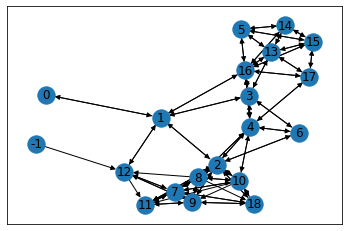

In [6]:
nx.draw_networkx(echo.brain, with_labels=True)

In [7]:
import numpy as np
weights = []

comp = sorted(nx.connected_components(echo.brain.to_undirected()), key=len, reverse=True)
ai_graph = echo.brain.subgraph(comp[0]).copy()

edges = list(ai_graph.edges(data=True))

for node, data in list(ai_graph.nodes(data=True)):
    name = data['roi_name']
    ai_graph.remove_node(node)
    ai_graph.add_node(int(node), roi_name=str(name))

for u, v, data in edges:
    if 'sequence' in data:
        weight = float(torch.mean(data['sequence'][0].weight.detach().flatten()).item())
        weights.append(weight)
        ai_graph.add_edge(u, v, weight=weight)
threshold = 2 * np.std(np.array(weights))

In [ ]:
for s, t, data in list(ai_graph.edges(data=True)):
    if np.abs(data['weight']) < threshold:
        ai_graph.remove_edge(s, t)

In [8]:
# rep graph
import graspologic as gr
pos_graph = ai_graph.copy()
for s, t, data in pos_graph.edges(data=True):
    pos_graph.edges[(s, t)]['weight'] = float(np.abs(data['weight']))
undirected_connectome, layout = gr.layouts.layout_tsne(pos_graph,
                                                       perplexity=10,
                                                       n_iter=1000)

/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [9]:
from graspologic.layouts.classes import NodePosition
for i in range(len(layout)):
    new_data = gr.layouts.classes.NodePosition(node_id=int(layout[i].node_id),
                                               x=layout[i].x,
                                               y=layout[i].y,
                                               size=layout[i].size,
                                               community=layout[i].community)
    layout[i] = new_data
cmap = plt.get_cmap('viridis')

raw_edge_weights = np.array([edge[2]['weight'] for edge in undirected_connectome.edges(data=True)])
edge_weights = raw_edge_weights - min(raw_edge_weights)
edge_weights = edge_weights / max(edge_weights)

edge_colors = np.array([cmap(val) for val in edge_weights])

edge_widths = np.abs(raw_edge_weights) - np.min(raw_edge_weights)
edge_widths = edge_widths / max(edge_widths)
edge_widths = (1. * edge_widths) + .25

node_colors = ['#808080'] * len(undirected_connectome.nodes())
labels = {}
for n in undirected_connectome.nodes:
    if 'roi_name' in undirected_connectome.nodes[n]:
        labels[n] = undirected_connectome.nodes[n]['roi_name']
    else:
        labels[n] = 'unnamed'

In [10]:
# add edge colors
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r*255), int(g*255), int(b*255))


for i, n in enumerate(undirected_connectome.nodes()):
    ai_graph.nodes[n]['graphics'] = {'x': float(layout[i].x),
                                  'y': float(layout[i].y),
                                  'w': float(layout[i].size),
                                  'h': float(layout[i].size)}

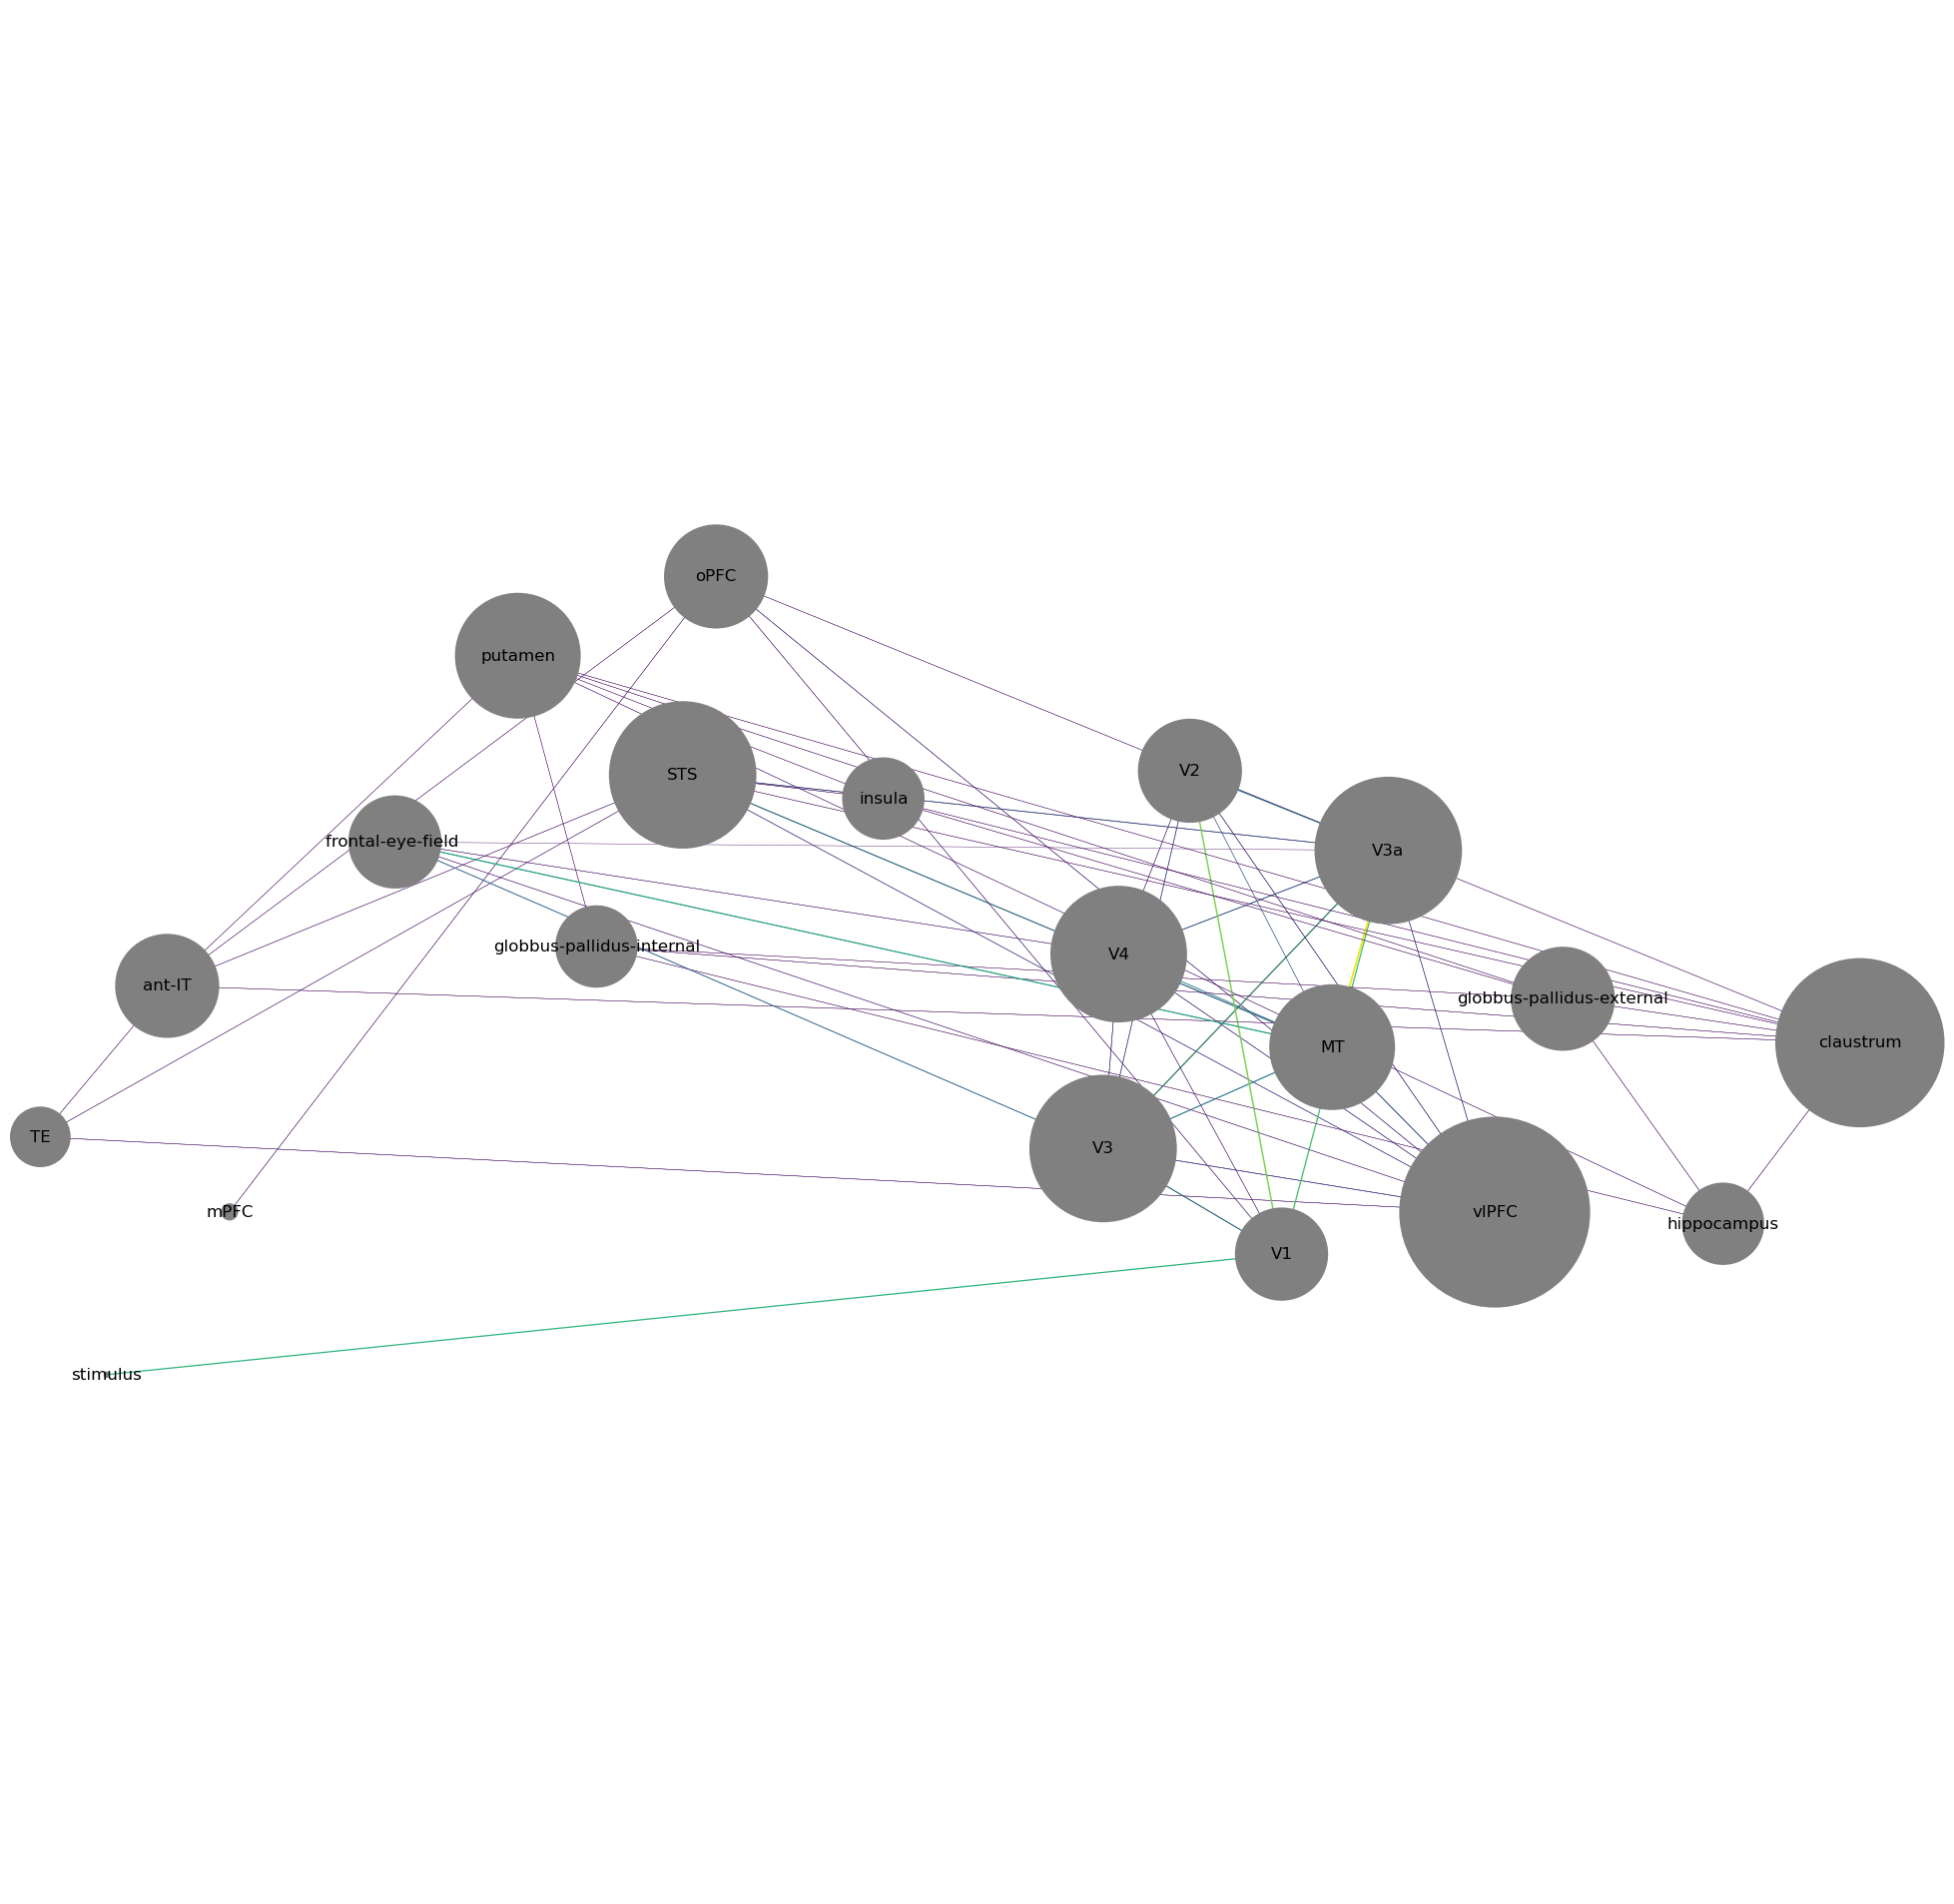

In [11]:
drawing = gr.layouts.render._draw_graph(undirected_connectome, layout, node_colors, 1.,
                                        edge_line_width=edge_widths,
                                        edge_alpha=1.,
                                        edge_colors=edge_colors,
                                        labels=labels,
                                        figure_width=25,
                                        figure_height=25)

In [12]:
data = nx.readwrite.write_gml(ai_graph, '/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/misc_testing_files/SL_cynetwork_out_mk1.gml')
